<a href="https://colab.research.google.com/github/lokkuuuu/Machine-Learning-for-medical-image-classification/blob/main/BreastHis_Densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Histology Image Classfication

## Mounting to Google Drive

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Change to working directory
%cd drive/MyDrive/BreakHis/

/content/drive/MyDrive/BreakHis


## Import Necessary Libraries

In [ ]:
#install required libraries
!pip install scikit-plot
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

#library for CNN
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Lambda, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

# Densenet+inception

## Function

In [ ]:
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128
def dataset(ds_path, *,
            train,
            preprocess_fn=None,
            image_size=IMAGE_SIZE,
            crop_size=CROP_SIZE,
            batch_size=BATCH_SIZE):
    """
    Dataset prepocess function by Saini, Manisha and Susan, Seba
    https://github.com/SainiManisha/VGGIN-Net
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        augment_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,[image],tf.float32),images)
        augment_images = tf.ensure_shape(augment_images, images.shape)
        return augment_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        crop_images = crop_layer(images, training = train)
        return crop_images, labels

    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    if preprocess_fn:
        ds = ds.map(preprocess_fn)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def evaluate_report(data,model):
  y_true = []
  y_pred = []
  for images, labels in data:
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)
  y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
  y_probas = y_pred
  y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)
  plot_confusion_matrix(y_true, y_pred, normalize=True)
  plot_roc(y_true, y_probas)
  plot_precision_recall(y_true,y_probas)

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
def plot_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #Getting the losses
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #No of epochs it trained
  epochs_range = history.epoch
  #Plotting Training and Validation accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.style.use('ggplot')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle = "dashed")
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Plotting Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.style.use('ggplot')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle = "dashed")
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

##MIB

In [ ]:
def densenet_builder():
    base_model = DenseNet201(include_top=False, input_shape=(224, 224, 3))
    stop_layer = 'pool4_pool'
    pre_model = Model(inputs = base_model.input, outputs = base_model.get_layer(stop_layer).output)
    pre_model.trainable = False

    preprocess_layer = Lambda(densenet_preprocess, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = pre_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def naive_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 3x3 conv
        conv3 = Conv2D(128, (3,3), padding='same', activation='relu')(input_layer)
        # 5x5 conv
        conv5 = Conv2D(32, (5,5), padding='same', activation='relu')(input_layer)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        # concatenate filters, assumes filters/channels last
        output_layer = Concatenate()([conv1, conv3, conv5, pool])
        return output_layer

    fin_out = naive_inception_module(pre_model.output)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(2, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
train_generation = dataset("./training_image/",train = True)
val_generation = dataset("./validating_image/",train = False)

Found 8758 files belonging to 2 classes.
Found 712 files belonging to 2 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
#build the model
model = densenet_builder()
model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d (Conv2D)           

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.8530

69/69 [==============================] - 540s 7s/step - loss: 0.5283 - accuracy: 0.8530 - val_loss: 0.5539 - val_accuracy: 0.8975
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8781

69/69 [==============================] - 105s 1s/step - loss: 0.4127 - accuracy: 0.8781 - val_loss: 0.3730 - val_accuracy: 0.8975
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8960

69/69 [==============================] - 105s 1s/step - loss: 0.3611 - accuracy: 0.8960 - val_loss: 0.3258 - val_accuracy: 0.8722
Epoch 4/50
69/69 [==============================] - 55s 709ms/step - loss: 0.3902 - accuracy: 0.8890 - val_loss: 0.3852 - val_accuracy: 0.8469
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.9125

69/69 [==============================] - 110s 2s/step - loss: 0.2959 - accuracy: 0.9125 - val_loss: 0.3019 - val_accuracy: 0.9017
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.9140

69/69 [==============================] - 110s 2s/step - loss: 0.2883 - accuracy: 0.9140 - val_loss: 0.2007 - val_accuracy: 0.9396
Epoch 7/50
69/69 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9227

69/69 [==============================] - 112s 2s/step - loss: 0.2590 - accuracy: 0.9227 - val_loss: 0.1754 - val_accuracy: 0.9284
Epoch 8/50
69/69 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9253

69/69 [==============================] - 110s 2s/step - loss: 0.2585 - accuracy: 0.9253 - val_loss: 0.1549 - val_accuracy: 0.9551
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9296

69/69 [==============================] - 108s 1s/step - loss: 0.2317 - accuracy: 0.9296 - val_loss: 0.1401 - val_accuracy: 0.9494
Epoch 10/50
69/69 [==============================] - 56s 727ms/step - loss: 0.2104 - accuracy: 0.9350 - val_loss: 0.1621 - val_accuracy: 0.9508
Epoch 11/50
69/69 [==============================] - 55s 717ms/step - loss: 0.2131 - accuracy: 0.9366 - val_loss: 0.1633 - val_accuracy: 0.9593
Epoch 12/50
69/69 [==============================] - 55s 725ms/step - loss: 0.1893 - accuracy: 0.9405 - val_loss: 0.1429 - val_accuracy: 0.9579
Epoch 13/50
69/69 [==============================] - 55s 714ms/step - loss: 0.1846 - accuracy: 0.9470 - val_loss: 0.1948 - val_accuracy: 0.9494
Epoch 14/50
69/69 [==============================] - 55s 716ms/step - loss: 0.1824 - accuracy: 0.9463 - val_loss: 0.2499 - val_accuracy: 0.9368


In [ ]:
model.save('Densenet_inception_model.h5')

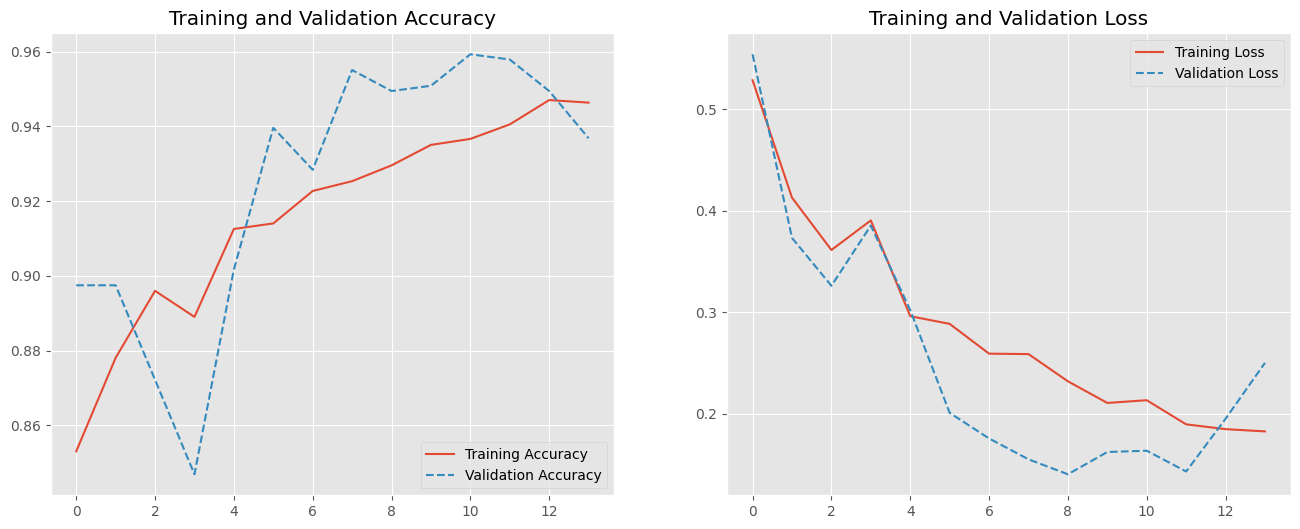

In [ ]:
plot_result(history)

In [ ]:
#Loading the test data using Image Data Generator
test_gen = dataset("./testing_image/",train = False)

Found 791 files belonging to 2 classes.


In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 36s 5s/step - loss: 0.2923 - accuracy: 0.9204


Evaluate model with test set:
1/1 [==============================] - 2s 2s/step
Accuracy:  0.9203539823008849
              precision    recall  f1-score   support

           0       0.81      0.98      0.88       242
           1       0.99      0.90      0.94       549

    accuracy                           0.92       791
   macro avg       0.90      0.94      0.91       791
weighted avg       0.93      0.92      0.92       791



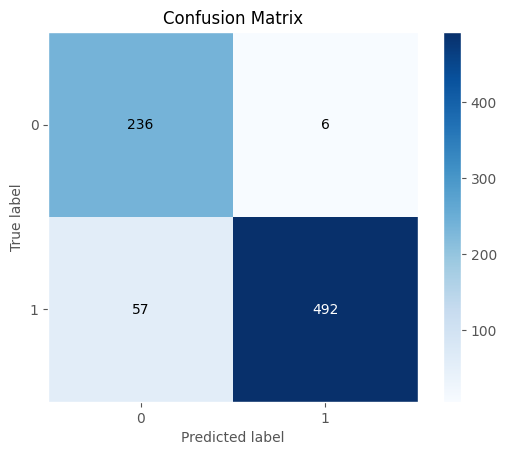

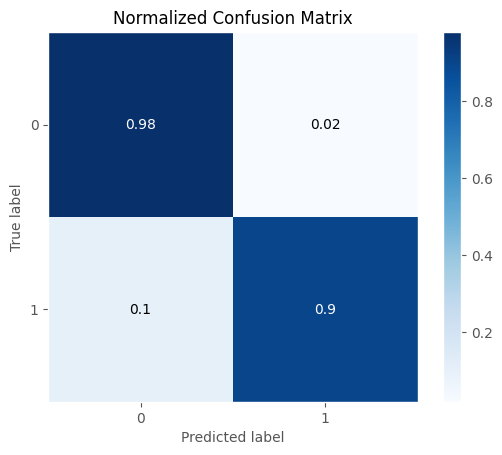

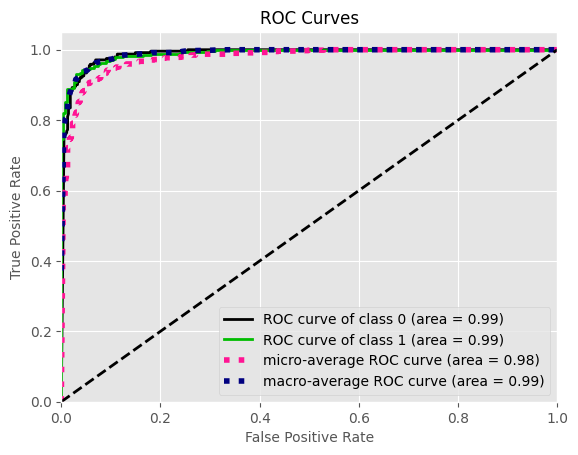

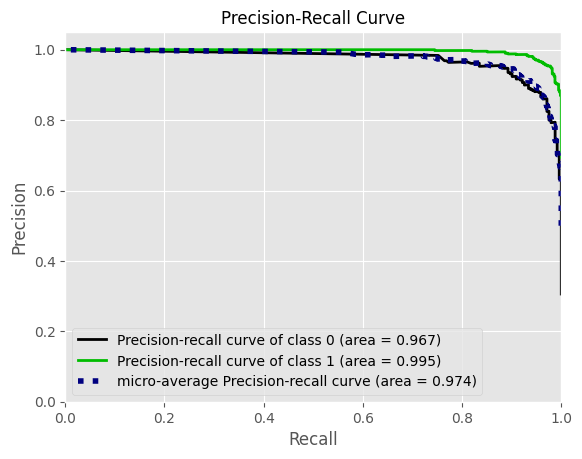

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

## MSB

### 40x

In [ ]:
train_generation = dataset("./msb/40/training_image/",train = True)
val_generation = dataset("./msb/40/validating_image/",train = False)
test_gen = dataset("./msb/40/testing_image/",train = False)

Found 2158 files belonging to 2 classes.
Found 192 files belonging to 2 classes.
Found 204 files belonging to 2 classes.


In [ ]:
#build the model
model = densenet_builder()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     57408       ['model_4[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.8383

17/17 [==============================] - 159s 6s/step - loss: 0.6118 - accuracy: 0.8383 - val_loss: 0.6033 - val_accuracy: 0.6302
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.9096

17/17 [==============================] - 67s 4s/step - loss: 0.3277 - accuracy: 0.9096 - val_loss: 0.5731 - val_accuracy: 0.6979
Epoch 3/50
17/17 [==============================] - 15s 556ms/step - loss: 0.2752 - accuracy: 0.9189 - val_loss: 0.6709 - val_accuracy: 0.4792
Epoch 4/50
17/17 [==============================] - 15s 554ms/step - loss: 0.2291 - accuracy: 0.9296 - val_loss: 0.6454 - val_accuracy: 0.5417
Epoch 5/50
17/17 [==============================] - 15s 560ms/step - loss: 0.2143 - accuracy: 0.9365 - val_loss: 0.5921 - val_accuracy: 0.5885
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9449

17/17 [==============================] - 67s 4s/step - loss: 0.1860 - accuracy: 0.9449 - val_loss: 0.3476 - val_accuracy: 0.9479
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9416

17/17 [==============================] - 68s 4s/step - loss: 0.2078 - accuracy: 0.9416 - val_loss: 0.3317 - val_accuracy: 0.9375
Epoch 8/50
17/17 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9541

17/17 [==============================] - 69s 4s/step - loss: 0.1513 - accuracy: 0.9541 - val_loss: 0.2812 - val_accuracy: 0.9531
Epoch 9/50
17/17 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9574

17/17 [==============================] - 69s 4s/step - loss: 0.1189 - accuracy: 0.9574 - val_loss: 0.2766 - val_accuracy: 0.9375
Epoch 10/50
17/17 [==============================] - 15s 565ms/step - loss: 0.1090 - accuracy: 0.9676 - val_loss: 0.3871 - val_accuracy: 0.8281
Epoch 11/50
17/17 [==============================] - 15s 539ms/step - loss: 0.1092 - accuracy: 0.9643 - val_loss: 0.3950 - val_accuracy: 0.8281
Epoch 12/50
17/17 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9625

17/17 [==============================] - 67s 4s/step - loss: 0.1159 - accuracy: 0.9625 - val_loss: 0.1672 - val_accuracy: 0.9583
Epoch 13/50
17/17 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9615

17/17 [==============================] - 67s 4s/step - loss: 0.1132 - accuracy: 0.9615 - val_loss: 0.1387 - val_accuracy: 0.9583
Epoch 14/50
17/17 [==============================] - 15s 520ms/step - loss: 0.0955 - accuracy: 0.9717 - val_loss: 0.1469 - val_accuracy: 0.9427
Epoch 15/50
17/17 [==============================] - 15s 526ms/step - loss: 0.0940 - accuracy: 0.9685 - val_loss: 0.1768 - val_accuracy: 0.9375
Epoch 16/50
17/17 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9782

17/17 [==============================] - 68s 4s/step - loss: 0.0643 - accuracy: 0.9782 - val_loss: 0.0839 - val_accuracy: 0.9792
Epoch 17/50
17/17 [==============================] - 16s 587ms/step - loss: 0.0838 - accuracy: 0.9717 - val_loss: 0.1198 - val_accuracy: 0.9427
Epoch 18/50
17/17 [==============================] - 15s 556ms/step - loss: 0.0711 - accuracy: 0.9773 - val_loss: 0.0910 - val_accuracy: 0.9740
Epoch 19/50
17/17 [==============================] - 15s 561ms/step - loss: 0.0855 - accuracy: 0.9736 - val_loss: 0.1147 - val_accuracy: 0.9531
Epoch 20/50
17/17 [==============================] - 16s 583ms/step - loss: 0.0611 - accuracy: 0.9819 - val_loss: 0.3975 - val_accuracy: 0.8333
Epoch 21/50
17/17 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9708

17/17 [==============================] - 68s 4s/step - loss: 0.0859 - accuracy: 0.9708 - val_loss: 0.0767 - val_accuracy: 0.9740
Epoch 22/50
17/17 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9796

17/17 [==============================] - 68s 4s/step - loss: 0.0719 - accuracy: 0.9796 - val_loss: 0.0651 - val_accuracy: 0.9740
Epoch 23/50
17/17 [==============================] - 15s 548ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0828 - val_accuracy: 0.9635
Epoch 24/50
17/17 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9838

17/17 [==============================] - 67s 4s/step - loss: 0.0627 - accuracy: 0.9838 - val_loss: 0.0505 - val_accuracy: 0.9792
Epoch 25/50
17/17 [==============================] - 16s 572ms/step - loss: 0.0435 - accuracy: 0.9880 - val_loss: 0.0706 - val_accuracy: 0.9740
Epoch 26/50
17/17 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9847

17/17 [==============================] - 68s 4s/step - loss: 0.0527 - accuracy: 0.9847 - val_loss: 0.0478 - val_accuracy: 0.9688
Epoch 27/50
17/17 [==============================] - 16s 564ms/step - loss: 0.0586 - accuracy: 0.9829 - val_loss: 0.1353 - val_accuracy: 0.9427
Epoch 28/50
17/17 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9838

17/17 [==============================] - 67s 4s/step - loss: 0.0539 - accuracy: 0.9838 - val_loss: 0.0356 - val_accuracy: 0.9844
Epoch 29/50
17/17 [==============================] - 15s 558ms/step - loss: 0.0387 - accuracy: 0.9884 - val_loss: 0.0655 - val_accuracy: 0.9688
Epoch 30/50
17/17 [==============================] - 16s 558ms/step - loss: 0.0411 - accuracy: 0.9889 - val_loss: 0.0591 - val_accuracy: 0.9688
Epoch 31/50
17/17 [==============================] - 15s 555ms/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.0818 - val_accuracy: 0.9792
Epoch 32/50
17/17 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9833

17/17 [==============================] - 68s 4s/step - loss: 0.0567 - accuracy: 0.9833 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 33/50
17/17 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9889

17/17 [==============================] - 68s 4s/step - loss: 0.0388 - accuracy: 0.9889 - val_loss: 0.0206 - val_accuracy: 0.9948
Epoch 34/50
17/17 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9907

17/17 [==============================] - 67s 4s/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.0201 - val_accuracy: 0.9896
Epoch 35/50
17/17 [==============================] - 15s 541ms/step - loss: 0.0405 - accuracy: 0.9847 - val_loss: 0.0425 - val_accuracy: 0.9740
Epoch 36/50
17/17 [==============================] - 15s 553ms/step - loss: 0.0578 - accuracy: 0.9842 - val_loss: 0.0476 - val_accuracy: 0.9896
Epoch 37/50
17/17 [==============================] - 16s 579ms/step - loss: 0.0484 - accuracy: 0.9833 - val_loss: 0.0291 - val_accuracy: 0.9844
Epoch 38/50
17/17 [==============================] - 15s 560ms/step - loss: 0.0360 - accuracy: 0.9903 - val_loss: 0.0269 - val_accuracy: 0.9844
Epoch 39/50
17/17 [==============================] - 15s 548ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.1938 - val_accuracy: 0.9583


In [ ]:
model.save('Densenet_inception_40_model.h5')

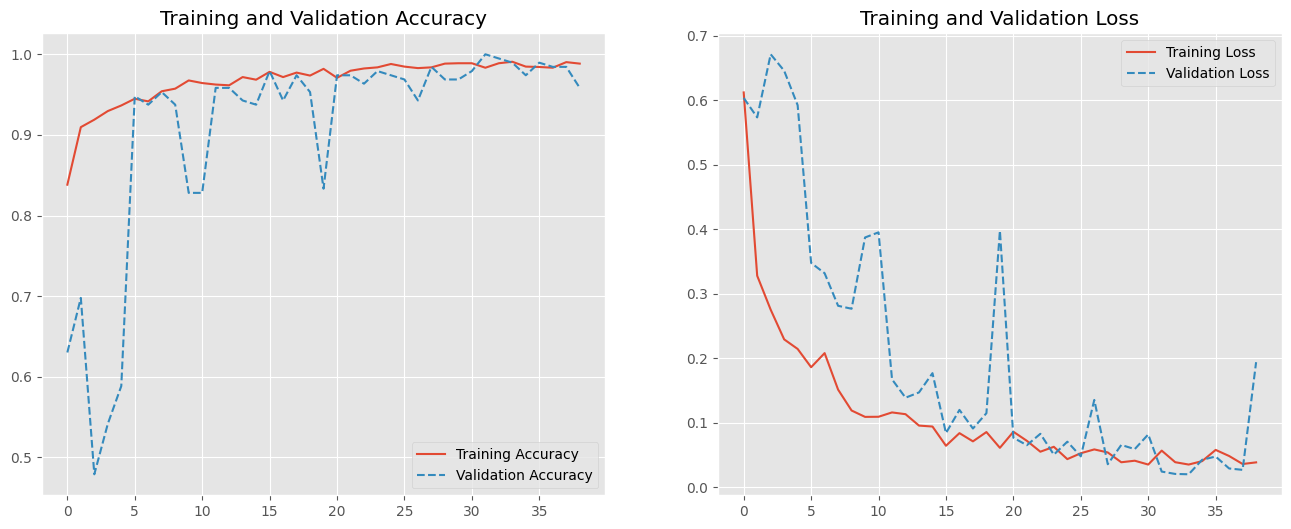

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 11s 4s/step - loss: 0.1687 - accuracy: 0.9657


In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_40_model.h5")

Evaluate model with test set:
3/3 [==============================] - 5s 1s/step
Accuracy:  0.9656862745098039
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        58
           1       0.99      0.96      0.98       146

    accuracy                           0.97       204
   macro avg       0.95      0.97      0.96       204
weighted avg       0.97      0.97      0.97       204



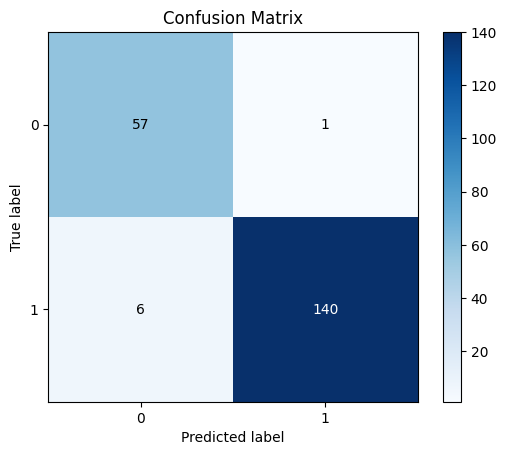

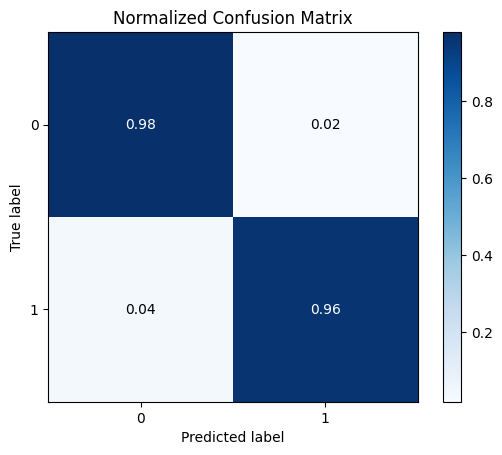

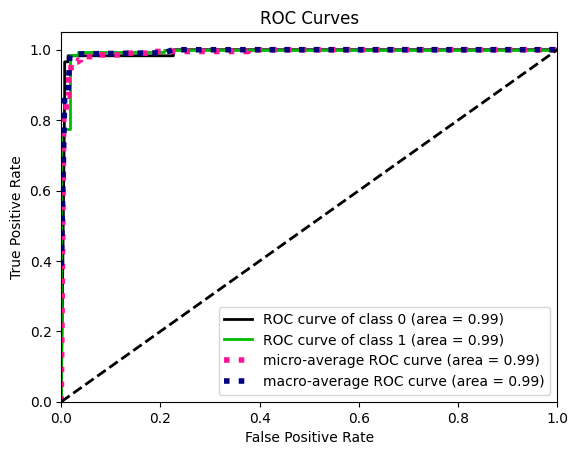

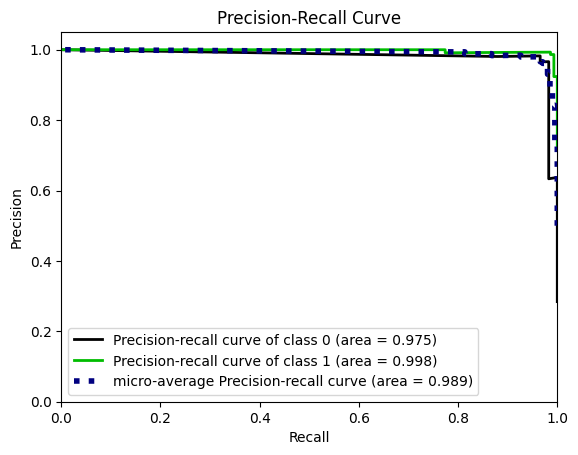

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### 100X

In [ ]:
train_generation = dataset("./msb/100/training_image/",train = True)
val_generation = dataset("./msb/100/validating_image/",train = False)
test_gen = dataset("./msb/100/testing_image/",train = False)

Found 2389 files belonging to 2 classes.
Found 175 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


In [ ]:
#build the model
model = densenet_builder()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 model_7 (Functional)           (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)              (None, 7, 7, 64)     57408       ['model_7[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.8497

19/19 [==============================] - 159s 6s/step - loss: 0.5765 - accuracy: 0.8497 - val_loss: 0.5894 - val_accuracy: 0.7143
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9113

19/19 [==============================] - 69s 3s/step - loss: 0.3224 - accuracy: 0.9113 - val_loss: 0.5712 - val_accuracy: 0.6800
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.9159

19/19 [==============================] - 71s 4s/step - loss: 0.3135 - accuracy: 0.9159 - val_loss: 0.4896 - val_accuracy: 0.8514
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9213

19/19 [==============================] - 70s 4s/step - loss: 0.2736 - accuracy: 0.9213 - val_loss: 0.4418 - val_accuracy: 0.9429
Epoch 5/50
19/19 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9397

19/19 [==============================] - 70s 3s/step - loss: 0.2106 - accuracy: 0.9397 - val_loss: 0.3812 - val_accuracy: 0.9257
Epoch 6/50
19/19 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9251

19/19 [==============================] - 71s 4s/step - loss: 0.2432 - accuracy: 0.9251 - val_loss: 0.3233 - val_accuracy: 0.9314
Epoch 7/50
19/19 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9301

19/19 [==============================] - 71s 4s/step - loss: 0.2354 - accuracy: 0.9301 - val_loss: 0.2994 - val_accuracy: 0.9371
Epoch 8/50
19/19 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9376

19/19 [==============================] - 70s 4s/step - loss: 0.1846 - accuracy: 0.9376 - val_loss: 0.2982 - val_accuracy: 0.9543
Epoch 9/50
19/19 [==============================] - 17s 566ms/step - loss: 0.1804 - accuracy: 0.9460 - val_loss: 0.3159 - val_accuracy: 0.8457
Epoch 10/50
19/19 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9380

19/19 [==============================] - 72s 4s/step - loss: 0.2168 - accuracy: 0.9380 - val_loss: 0.2172 - val_accuracy: 0.9200
Epoch 11/50
19/19 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9544

19/19 [==============================] - 73s 4s/step - loss: 0.1605 - accuracy: 0.9544 - val_loss: 0.2053 - val_accuracy: 0.9543
Epoch 12/50
19/19 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9531

19/19 [==============================] - 71s 4s/step - loss: 0.1588 - accuracy: 0.9531 - val_loss: 0.1886 - val_accuracy: 0.9486
Epoch 13/50
19/19 [==============================] - 17s 588ms/step - loss: 0.1463 - accuracy: 0.9535 - val_loss: 0.2679 - val_accuracy: 0.8914
Epoch 14/50
19/19 [==============================] - 18s 593ms/step - loss: 0.1856 - accuracy: 0.9477 - val_loss: 0.3130 - val_accuracy: 0.8629
Epoch 15/50
19/19 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9565

19/19 [==============================] - 73s 4s/step - loss: 0.1385 - accuracy: 0.9565 - val_loss: 0.1827 - val_accuracy: 0.9200
Epoch 16/50
19/19 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9619

19/19 [==============================] - 72s 4s/step - loss: 0.1170 - accuracy: 0.9619 - val_loss: 0.1577 - val_accuracy: 0.9486
Epoch 17/50
19/19 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9540

19/19 [==============================] - 72s 4s/step - loss: 0.1483 - accuracy: 0.9540 - val_loss: 0.1342 - val_accuracy: 0.9600
Epoch 18/50
19/19 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9640

19/19 [==============================] - 71s 4s/step - loss: 0.1230 - accuracy: 0.9640 - val_loss: 0.1181 - val_accuracy: 0.9657
Epoch 19/50
19/19 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9682

19/19 [==============================] - 71s 4s/step - loss: 0.1065 - accuracy: 0.9682 - val_loss: 0.1107 - val_accuracy: 0.9543
Epoch 20/50
19/19 [==============================] - 17s 579ms/step - loss: 0.1312 - accuracy: 0.9678 - val_loss: 0.1291 - val_accuracy: 0.9486
Epoch 21/50
19/19 [==============================] - 17s 576ms/step - loss: 0.0835 - accuracy: 0.9757 - val_loss: 0.1539 - val_accuracy: 0.9486
Epoch 22/50
19/19 [==============================] - 16s 560ms/step - loss: 0.0804 - accuracy: 0.9761 - val_loss: 0.1194 - val_accuracy: 0.9600
Epoch 23/50
19/19 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9715

19/19 [==============================] - 70s 3s/step - loss: 0.0946 - accuracy: 0.9715 - val_loss: 0.0806 - val_accuracy: 0.9657
Epoch 24/50
19/19 [==============================] - 17s 578ms/step - loss: 0.0748 - accuracy: 0.9745 - val_loss: 0.2093 - val_accuracy: 0.9371
Epoch 25/50
19/19 [==============================] - 17s 572ms/step - loss: 0.0743 - accuracy: 0.9766 - val_loss: 0.0855 - val_accuracy: 0.9600
Epoch 26/50
19/19 [==============================] - 16s 570ms/step - loss: 0.0889 - accuracy: 0.9728 - val_loss: 0.1018 - val_accuracy: 0.9714
Epoch 27/50
19/19 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9724

19/19 [==============================] - 70s 4s/step - loss: 0.1086 - accuracy: 0.9724 - val_loss: 0.0670 - val_accuracy: 0.9771
Epoch 28/50
19/19 [==============================] - 17s 572ms/step - loss: 0.0724 - accuracy: 0.9770 - val_loss: 0.0751 - val_accuracy: 0.9657
Epoch 29/50
19/19 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9724

19/19 [==============================] - 70s 4s/step - loss: 0.0830 - accuracy: 0.9724 - val_loss: 0.0453 - val_accuracy: 0.9771
Epoch 30/50
19/19 [==============================] - 17s 576ms/step - loss: 0.0916 - accuracy: 0.9761 - val_loss: 0.1121 - val_accuracy: 0.9657
Epoch 31/50
19/19 [==============================] - 17s 551ms/step - loss: 0.0724 - accuracy: 0.9787 - val_loss: 0.0892 - val_accuracy: 0.9771
Epoch 32/50
19/19 [==============================] - 17s 571ms/step - loss: 0.0712 - accuracy: 0.9778 - val_loss: 0.0887 - val_accuracy: 0.9771
Epoch 33/50
19/19 [==============================] - 17s 566ms/step - loss: 0.0492 - accuracy: 0.9828 - val_loss: 0.0576 - val_accuracy: 0.9829
Epoch 34/50
19/19 [==============================] - 17s 597ms/step - loss: 0.0599 - accuracy: 0.9803 - val_loss: 0.0737 - val_accuracy: 0.9714


In [ ]:
model.save('Densenet_inception_100_model.h5')

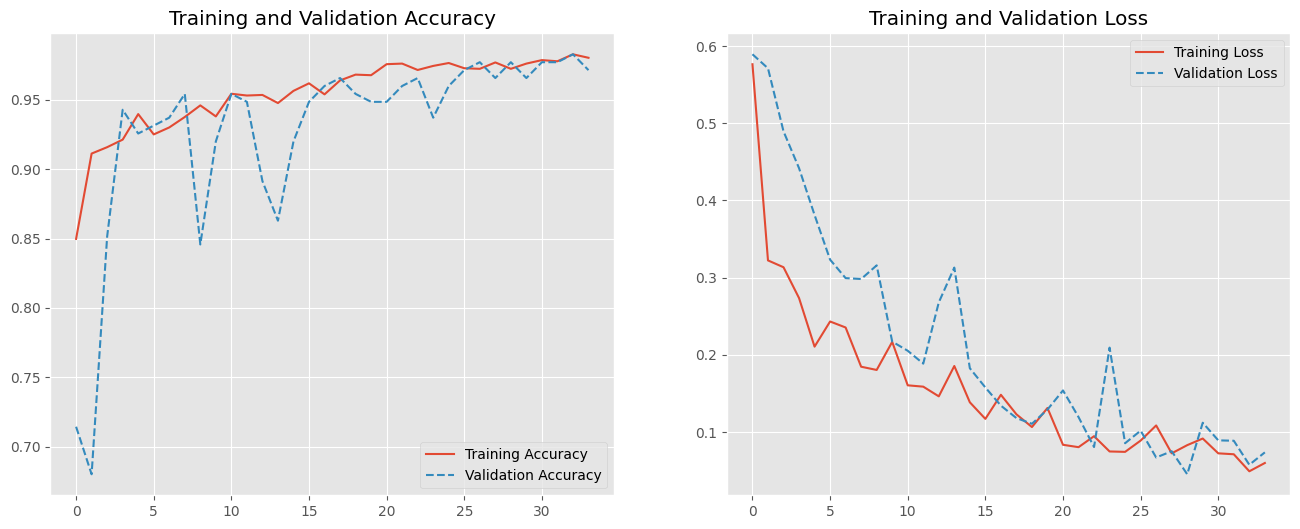

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_100_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 10s 4s/step - loss: 0.1372 - accuracy: 0.9632


Evaluate model with test set:
2/2 [==============================] - 6s 3s/step
Accuracy:  0.9631578947368421
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        55
           1       0.99      0.96      0.97       135

    accuracy                           0.96       190
   macro avg       0.95      0.97      0.96       190
weighted avg       0.97      0.96      0.96       190



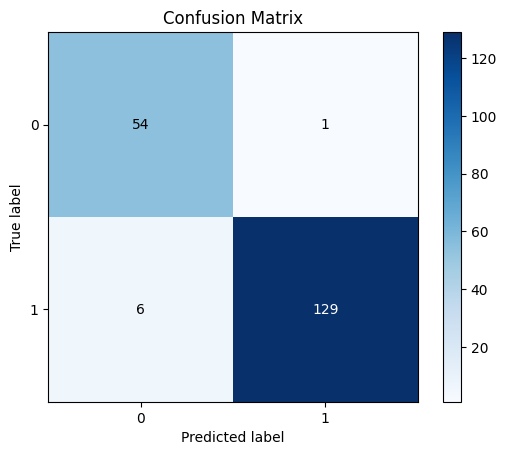

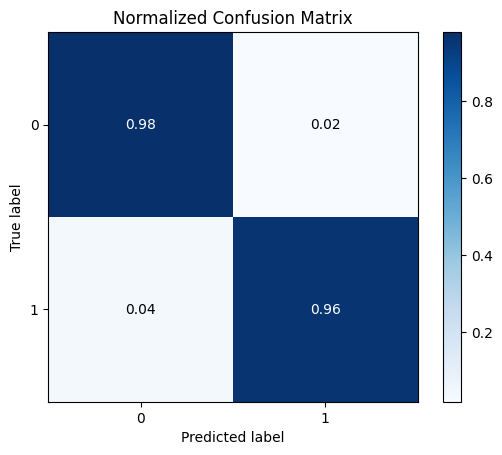

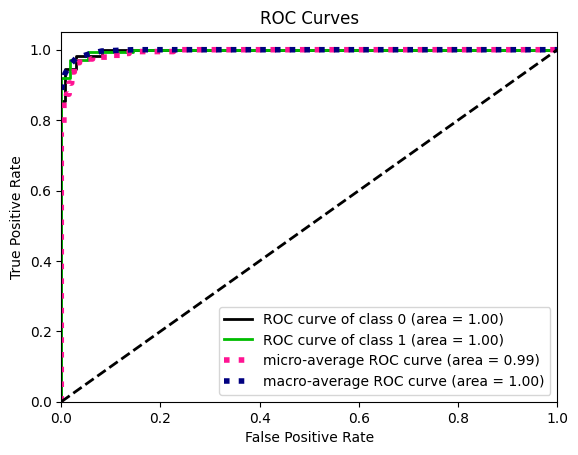

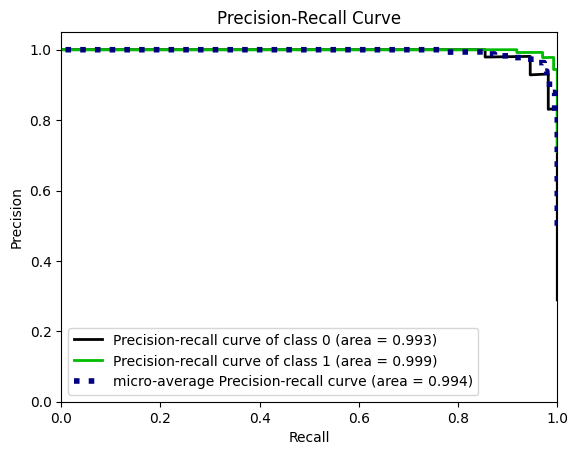

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### 200X

In [ ]:
train_generation = dataset("./msb/200/training_image/",train = True)
val_generation = dataset("./msb/200/validating_image/",train = False)
test_gen = dataset("./msb/200/testing_image/",train = False)

Found 2215 files belonging to 2 classes.
Found 191 files belonging to 2 classes.
Found 211 files belonging to 2 classes.


In [ ]:
#build the model
model = densenet_builder()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 model_3 (Functional)           (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     57408       ['model_3[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.8284

18/18 [==============================] - 136s 6s/step - loss: 0.7125 - accuracy: 0.8284 - val_loss: 0.5246 - val_accuracy: 0.9005
Epoch 2/50
18/18 [==============================] - 67s 3s/step - loss: 0.3590 - accuracy: 0.9043 - val_loss: 0.5595 - val_accuracy: 0.8848
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8953

18/18 [==============================] - 128s 7s/step - loss: 0.3416 - accuracy: 0.8953 - val_loss: 0.4421 - val_accuracy: 0.8848
Epoch 4/50
18/18 [==============================] - 68s 3s/step - loss: 0.2744 - accuracy: 0.9201 - val_loss: 0.5897 - val_accuracy: 0.7016
Epoch 5/50
18/18 [==============================] - 71s 3s/step - loss: 0.2392 - accuracy: 0.9210 - val_loss: 0.7050 - val_accuracy: 0.4346
Epoch 6/50
18/18 [==============================] - 65s 3s/step - loss: 0.2640 - accuracy: 0.9192 - val_loss: 0.4794 - val_accuracy: 0.8482
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9323

18/18 [==============================] - 130s 7s/step - loss: 0.2191 - accuracy: 0.9323 - val_loss: 0.3719 - val_accuracy: 0.9476
Epoch 8/50
18/18 [==============================] - 69s 3s/step - loss: 0.2510 - accuracy: 0.9255 - val_loss: 0.5947 - val_accuracy: 0.6440
Epoch 9/50
18/18 [==============================] - 67s 3s/step - loss: 0.1912 - accuracy: 0.9381 - val_loss: 0.4208 - val_accuracy: 0.8377
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9458

18/18 [==============================] - 129s 7s/step - loss: 0.1676 - accuracy: 0.9458 - val_loss: 0.3046 - val_accuracy: 0.9110
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9530

18/18 [==============================] - 129s 6s/step - loss: 0.1718 - accuracy: 0.9530 - val_loss: 0.2870 - val_accuracy: 0.8953
Epoch 12/50
18/18 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9603

18/18 [==============================] - 130s 7s/step - loss: 0.1379 - accuracy: 0.9603 - val_loss: 0.2221 - val_accuracy: 0.9476
Epoch 13/50
18/18 [==============================] - 68s 3s/step - loss: 0.1147 - accuracy: 0.9657 - val_loss: 0.3563 - val_accuracy: 0.8848
Epoch 14/50
18/18 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9517

18/18 [==============================] - 130s 7s/step - loss: 0.1409 - accuracy: 0.9517 - val_loss: 0.1730 - val_accuracy: 0.9476
Epoch 15/50
18/18 [==============================] - 71s 3s/step - loss: 0.1263 - accuracy: 0.9634 - val_loss: 0.2076 - val_accuracy: 0.9215
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9558

18/18 [==============================] - 131s 7s/step - loss: 0.1411 - accuracy: 0.9558 - val_loss: 0.1562 - val_accuracy: 0.9529
Epoch 17/50
18/18 [==============================] - 70s 3s/step - loss: 0.1950 - accuracy: 0.9463 - val_loss: 1.7441 - val_accuracy: 0.5759
Epoch 18/50
18/18 [==============================] - 68s 3s/step - loss: 0.1517 - accuracy: 0.9625 - val_loss: 0.6707 - val_accuracy: 0.7801
Epoch 19/50
18/18 [==============================] - 69s 3s/step - loss: 0.1323 - accuracy: 0.9643 - val_loss: 0.2886 - val_accuracy: 0.9110
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9634

18/18 [==============================] - 126s 6s/step - loss: 0.1240 - accuracy: 0.9634 - val_loss: 0.1378 - val_accuracy: 0.9476
Epoch 21/50
18/18 [==============================] - 70s 3s/step - loss: 0.1078 - accuracy: 0.9670 - val_loss: 0.1755 - val_accuracy: 0.9424
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9779

18/18 [==============================] - 126s 6s/step - loss: 0.0833 - accuracy: 0.9779 - val_loss: 0.1069 - val_accuracy: 0.9634
Epoch 23/50
18/18 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9729

18/18 [==============================] - 127s 6s/step - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.0747 - val_accuracy: 0.9686
Epoch 24/50
18/18 [==============================] - 69s 3s/step - loss: 0.1003 - accuracy: 0.9725 - val_loss: 0.1017 - val_accuracy: 0.9634
Epoch 25/50
18/18 [==============================] - 68s 3s/step - loss: 0.0714 - accuracy: 0.9783 - val_loss: 0.1404 - val_accuracy: 0.9529
Epoch 26/50
18/18 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9765

18/18 [==============================] - 129s 7s/step - loss: 0.0785 - accuracy: 0.9765 - val_loss: 0.0577 - val_accuracy: 0.9738
Epoch 27/50
18/18 [==============================] - 68s 3s/step - loss: 0.0809 - accuracy: 0.9752 - val_loss: 0.0798 - val_accuracy: 0.9791
Epoch 28/50
18/18 [==============================] - 68s 3s/step - loss: 0.0753 - accuracy: 0.9729 - val_loss: 0.0743 - val_accuracy: 0.9738
Epoch 29/50
18/18 [==============================] - 70s 3s/step - loss: 0.0407 - accuracy: 0.9869 - val_loss: 0.0774 - val_accuracy: 0.9581
Epoch 30/50
18/18 [==============================] - 68s 3s/step - loss: 0.0731 - accuracy: 0.9779 - val_loss: 0.0646 - val_accuracy: 0.9738
Epoch 31/50
18/18 [==============================] - 72s 3s/step - loss: 0.0742 - accuracy: 0.9774 - val_loss: 0.1017 - val_accuracy: 0.9581


In [ ]:
model.save('Densenet_inception_200_model.h5')

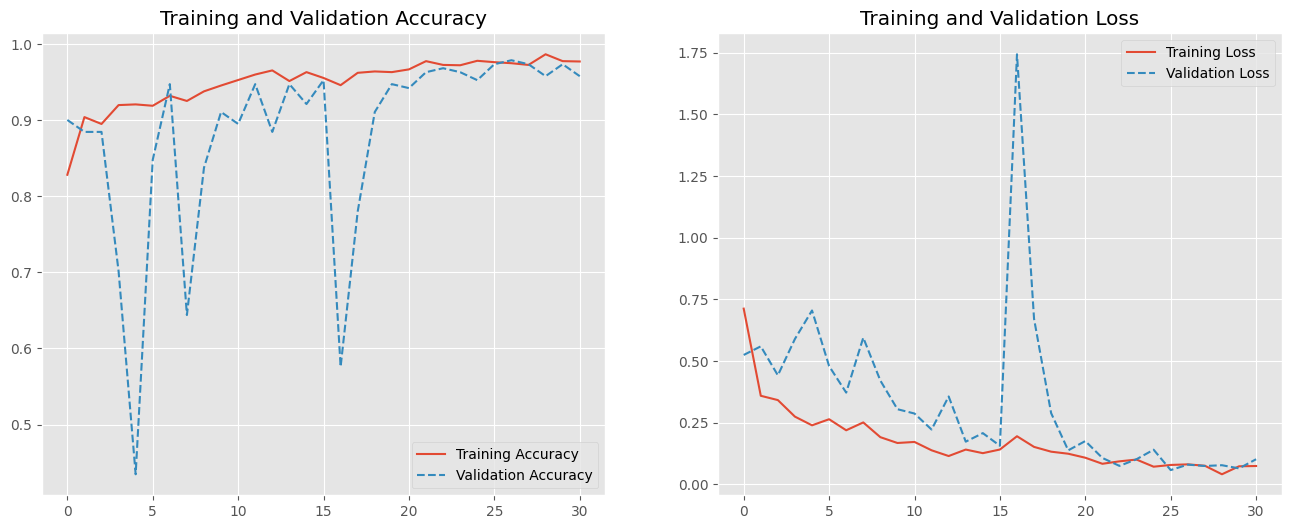

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_200_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 3s 696ms/step - loss: 0.0893 - accuracy: 0.9668


Evaluate model with test set:
3/3 [==============================] - 5s 2s/step
Accuracy:  0.966824644549763
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        64
           1       0.97      0.99      0.98       147

    accuracy                           0.97       211
   macro avg       0.97      0.95      0.96       211
weighted avg       0.97      0.97      0.97       211



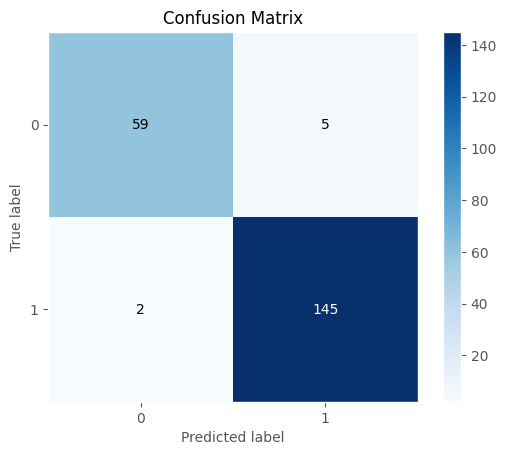

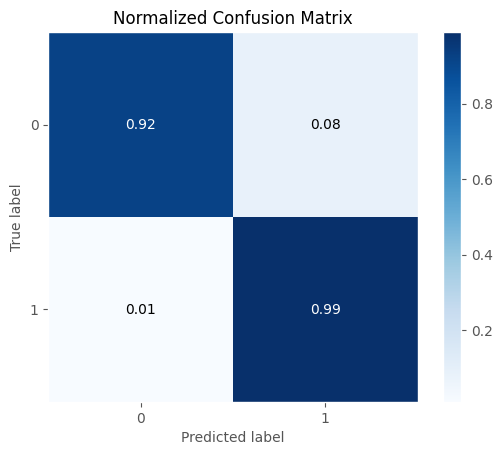

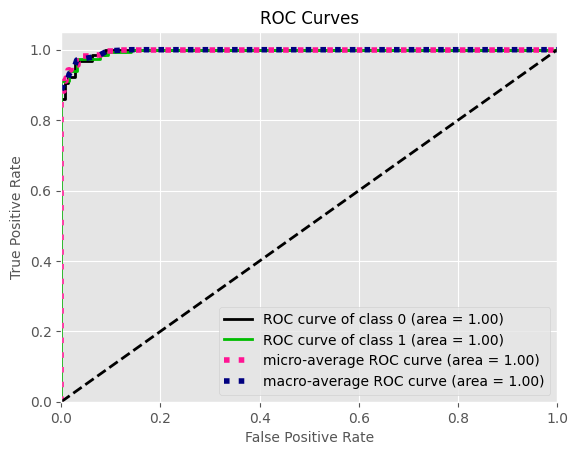

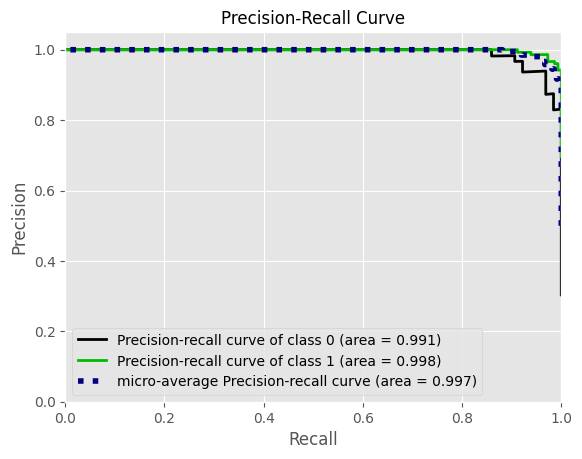

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### 400X

In [ ]:
train_generation = dataset("./msb/400/training_image/",train = True)
val_generation = dataset("./msb/400/validating_image/",train = False)
test_gen = dataset("./msb/400/testing_image/",train = False)

Found 1996 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
Found 186 files belonging to 2 classes.


In [ ]:
#build the model
model = densenet_builder()
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 model_13 (Functional)          (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)             (None, 7, 7, 64)     57408       ['model_13[0][0]']        

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
16/16 [==============================] - 14s 531ms/step - loss: 0.0920 - accuracy: 0.9729 - val_loss: 0.1660 - val_accuracy: 0.9416
Epoch 2/50
16/16 [==============================] - 14s 547ms/step - loss: 0.1275 - accuracy: 0.9664 - val_loss: 0.1996 - val_accuracy: 0.9221
Epoch 3/50
16/16 [==============================] - 14s 534ms/step - loss: 0.1422 - accuracy: 0.9559 - val_loss: 0.2212 - val_accuracy: 0.9286
Epoch 4/50
16/16 [==============================] - 15s 549ms/step - loss: 0.1050 - accuracy: 0.9669 - val_loss: 0.2221 - val_accuracy: 0.9481
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9714

16/16 [==============================] - 68s 4s/step - loss: 0.0941 - accuracy: 0.9714 - val_loss: 0.1068 - val_accuracy: 0.9610
Epoch 6/50
16/16 [==============================] - 15s 529ms/step - loss: 0.1164 - accuracy: 0.9669 - val_loss: 0.1648 - val_accuracy: 0.9481
Epoch 7/50
16/16 [==============================] - 14s 526ms/step - loss: 0.0988 - accuracy: 0.9704 - val_loss: 0.2079 - val_accuracy: 0.9416
Epoch 8/50
16/16 [==============================] - 14s 514ms/step - loss: 0.1095 - accuracy: 0.9709 - val_loss: 0.1410 - val_accuracy: 0.9416
Epoch 9/50
16/16 [==============================] - 14s 514ms/step - loss: 0.0564 - accuracy: 0.9845 - val_loss: 0.1820 - val_accuracy: 0.9481
Epoch 10/50
16/16 [==============================] - 14s 513ms/step - loss: 0.0508 - accuracy: 0.9830 - val_loss: 0.2820 - val_accuracy: 0.9481


In [ ]:
model.save('Densenet_inception_400_model.h5')

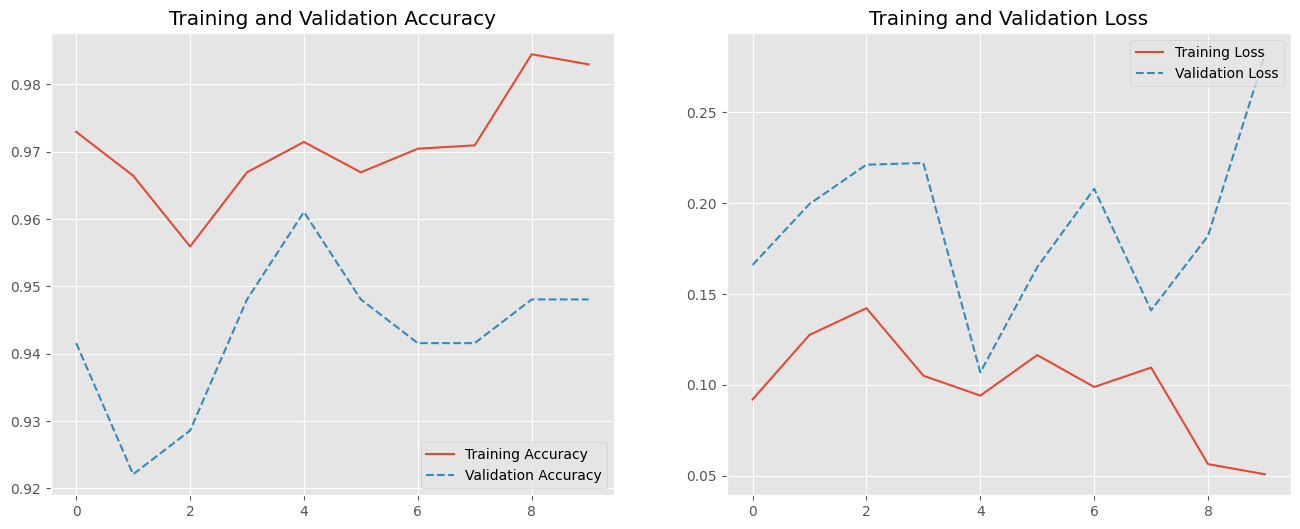

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_400_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 9s 3s/step - loss: 0.2695 - accuracy: 0.9409


Evaluate model with test set:


2/2 [==============================] - 5s 3s/step
Accuracy:  0.9247311827956989
              precision    recall  f1-score   support

           0       0.98      0.80      0.88        65
           1       0.90      0.99      0.94       121

    accuracy                           0.92       186
   macro avg       0.94      0.90      0.91       186
weighted avg       0.93      0.92      0.92       186



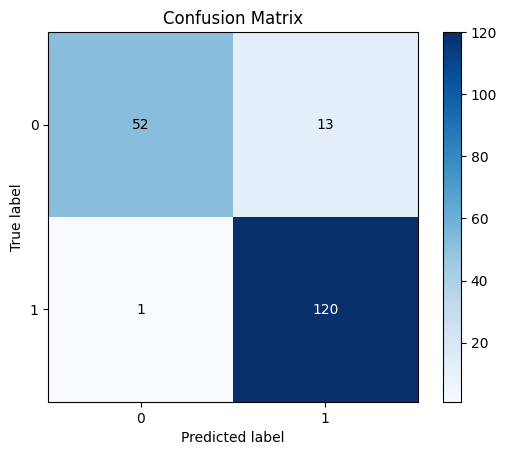

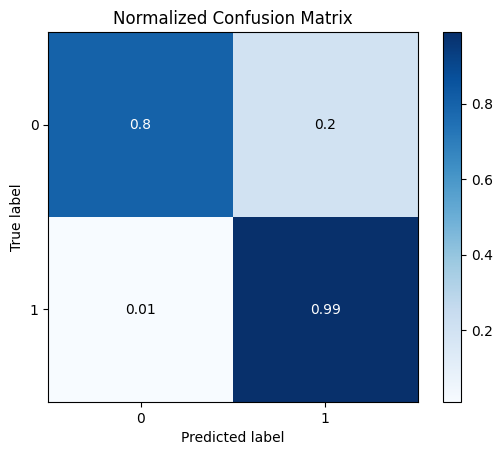

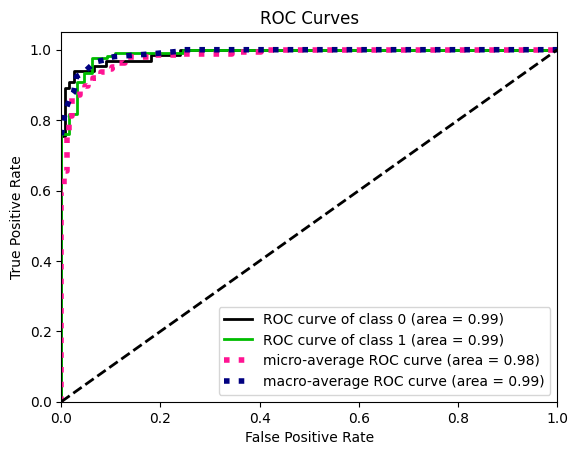

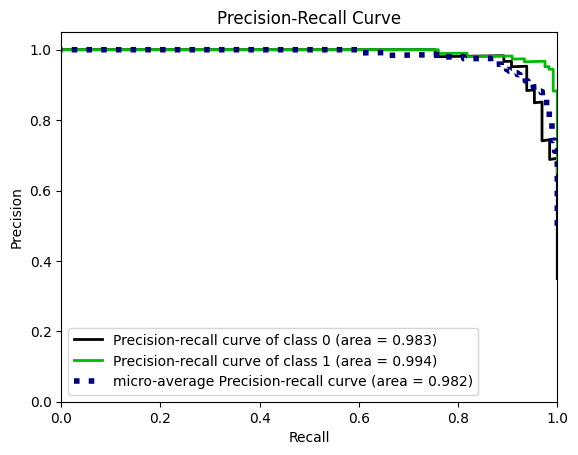

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

## MIM

In [ ]:
def densenet_Mbuilder():
    base_model = DenseNet201(include_top=False, input_shape=(224, 224, 3))
    stop_layer = 'pool4_pool'
    pre_model = Model(inputs = base_model.input, outputs = base_model.get_layer(stop_layer).output)
    pre_model.trainable = False

    preprocess_layer = Lambda(densenet_preprocess, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = pre_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def naive_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 3x3 conv
        conv3 = Conv2D(128, (3,3), padding='same', activation='relu')(input_layer)
        # 5x5 conv
        conv5 = Conv2D(32, (5,5), padding='same', activation='relu')(input_layer)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        # concatenate filters, assumes filters/channels last
        output_layer = Concatenate()([conv1, conv3, conv5, pool])
        return output_layer

    fin_out = naive_inception_module(pre_model.output)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(8, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
train_generation = dataset("./subclass/training_image/",train = True)
val_generation = dataset("./subclass/validating_image/",train = False)
test_gen = dataset("./subclass/testing_image/",train = False)

Found 8758 files belonging to 8 classes.
Found 712 files belonging to 8 classes.
Found 791 files belonging to 8 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
#Defining the base model
model = densenet_Mbuilder()
model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 896)    11238464    ['preprocess[0][0]']             
                                                                                                  
 conv2d (Conv2D)           

In [ ]:
#Compiling the model
model.compile(loss='CategoricalCrossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.7888

69/69 [==============================] - 117s 2s/step - loss: 0.1896 - accuracy: 0.7888 - val_loss: 0.2010 - val_accuracy: 0.7556
Epoch 2/50
69/69 [==============================] - 59s 776ms/step - loss: 0.1861 - accuracy: 0.7916 - val_loss: 0.2271 - val_accuracy: 0.7486
Epoch 3/50
69/69 [==============================] - 60s 778ms/step - loss: 0.1792 - accuracy: 0.8028 - val_loss: 0.2257 - val_accuracy: 0.7626
Epoch 4/50
69/69 [==============================] - 59s 764ms/step - loss: 0.1722 - accuracy: 0.8083 - val_loss: 0.2115 - val_accuracy: 0.7640
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.8122

69/69 [==============================] - 116s 2s/step - loss: 0.1693 - accuracy: 0.8122 - val_loss: 0.1961 - val_accuracy: 0.7739
Epoch 6/50
69/69 [==============================] - 60s 779ms/step - loss: 0.1624 - accuracy: 0.8194 - val_loss: 0.2063 - val_accuracy: 0.7640
Epoch 7/50
69/69 [==============================] - 59s 767ms/step - loss: 0.1639 - accuracy: 0.8177 - val_loss: 0.1972 - val_accuracy: 0.7907
Epoch 8/50
69/69 [==============================] - 59s 768ms/step - loss: 0.1588 - accuracy: 0.8201 - val_loss: 0.2074 - val_accuracy: 0.7823
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.8317

69/69 [==============================] - 114s 2s/step - loss: 0.1487 - accuracy: 0.8317 - val_loss: 0.1913 - val_accuracy: 0.7809
Epoch 10/50
69/69 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.8348

69/69 [==============================] - 113s 2s/step - loss: 0.1461 - accuracy: 0.8348 - val_loss: 0.1819 - val_accuracy: 0.7949
Epoch 11/50
69/69 [==============================] - 59s 767ms/step - loss: 0.1490 - accuracy: 0.8322 - val_loss: 0.1881 - val_accuracy: 0.7949
Epoch 12/50
69/69 [==============================] - 59s 769ms/step - loss: 0.1425 - accuracy: 0.8415 - val_loss: 0.2132 - val_accuracy: 0.7711
Epoch 13/50
69/69 [==============================] - 58s 759ms/step - loss: 0.1399 - accuracy: 0.8409 - val_loss: 0.1951 - val_accuracy: 0.7865
Epoch 14/50
69/69 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.8496

69/69 [==============================] - 112s 2s/step - loss: 0.1332 - accuracy: 0.8496 - val_loss: 0.1765 - val_accuracy: 0.8118
Epoch 15/50
69/69 [==============================] - 58s 754ms/step - loss: 0.1353 - accuracy: 0.8462 - val_loss: 0.1825 - val_accuracy: 0.8132
Epoch 16/50
69/69 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.8566

69/69 [==============================] - 112s 2s/step - loss: 0.1287 - accuracy: 0.8566 - val_loss: 0.1743 - val_accuracy: 0.8244
Epoch 17/50
69/69 [==============================] - 59s 770ms/step - loss: 0.1348 - accuracy: 0.8497 - val_loss: 0.2072 - val_accuracy: 0.7767
Epoch 18/50
69/69 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.8616

69/69 [==============================] - 112s 2s/step - loss: 0.1235 - accuracy: 0.8616 - val_loss: 0.1719 - val_accuracy: 0.8062
Epoch 19/50
69/69 [==============================] - 59s 765ms/step - loss: 0.1282 - accuracy: 0.8530 - val_loss: 0.1913 - val_accuracy: 0.7837
Epoch 20/50
69/69 [==============================] - 58s 755ms/step - loss: 0.1274 - accuracy: 0.8556 - val_loss: 0.1806 - val_accuracy: 0.8048
Epoch 21/50
69/69 [==============================] - 59s 769ms/step - loss: 0.1202 - accuracy: 0.8625 - val_loss: 0.1998 - val_accuracy: 0.7725
Epoch 22/50
69/69 [==============================] - 58s 756ms/step - loss: 0.1203 - accuracy: 0.8663 - val_loss: 0.1772 - val_accuracy: 0.7935
Epoch 23/50
69/69 [==============================] - 58s 757ms/step - loss: 0.1201 - accuracy: 0.8649 - val_loss: 0.1889 - val_accuracy: 0.7893


In [ ]:
model.save('Densenet_inception_M_model.h5')

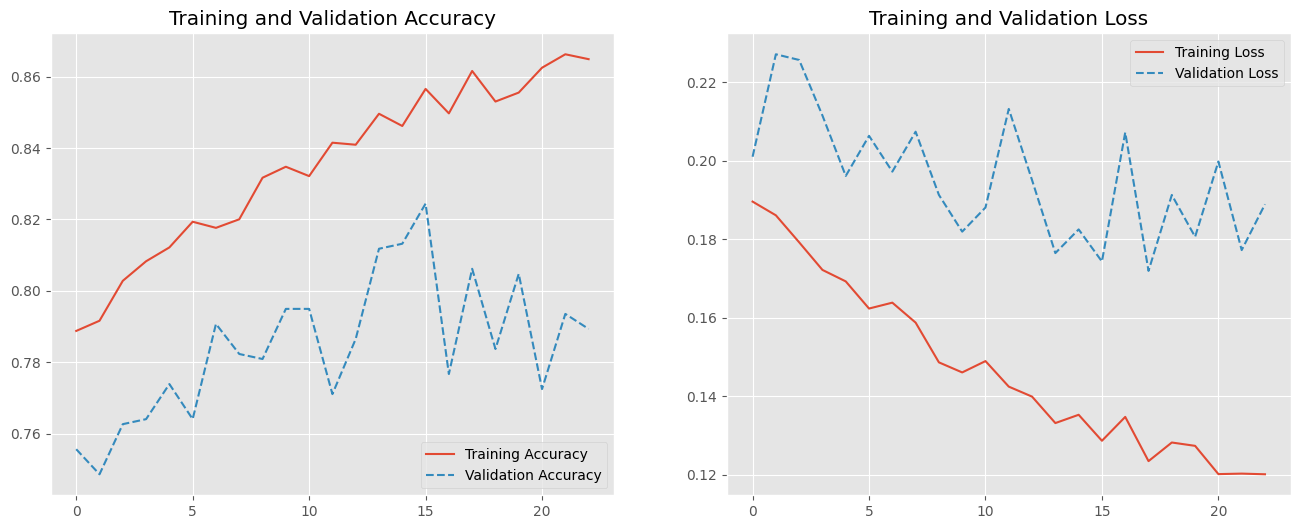

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Densenet_inception_M_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 52s 7s/step - loss: 0.1871 - accuracy: 0.7977


Evaluate model with test set:
1/1 [==============================] - 5s 5s/step
Accuracy:  0.797724399494311
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        45
           1       0.85      0.88      0.86       339
           2       0.76      0.88      0.82        95
           3       0.70      0.48      0.57        66
           4       0.98      0.53      0.69        88
           5       0.57      0.82      0.68        56
           6       0.89      0.65      0.75        49
           7       0.78      0.94      0.85        53

    accuracy                           0.80       791
   macro avg       0.79      0.77      0.76       791
weighted avg       0.81      0.80      0.79       791



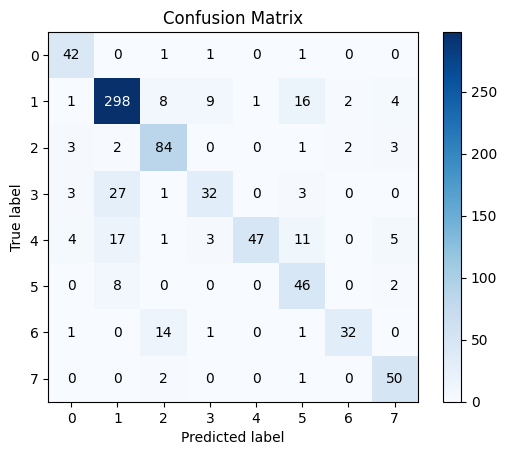

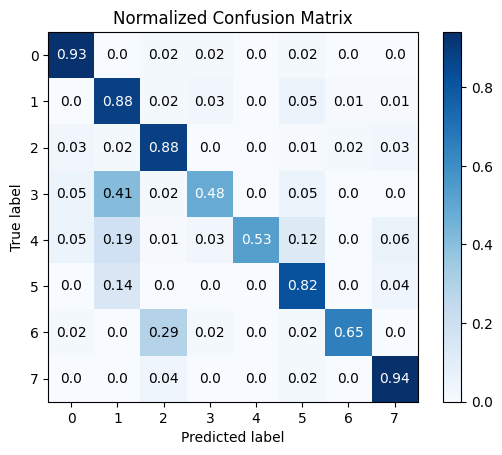

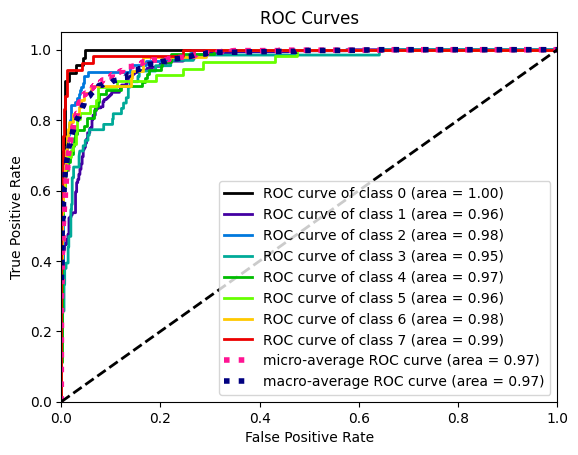

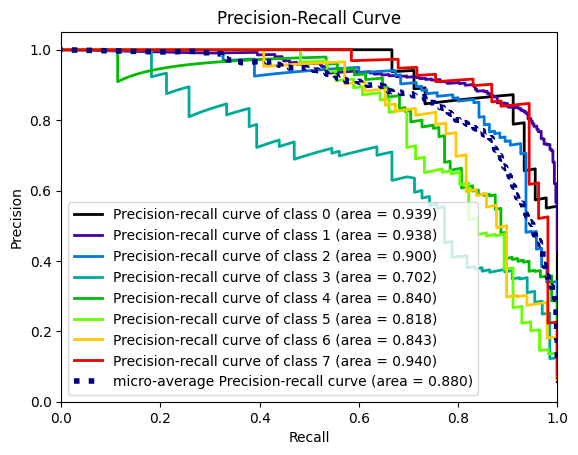

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### MIM mag test

In [ ]:
model = tf.keras.models.load_model("./Densenet_inception_M_model.h5")

####40x

In [ ]:
test_gen = dataset("./mag_test/40/",train = False)

Found 204 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 69s 12s/step - loss: 0.1682 - accuracy: 0.7843


Evaluate model with test set:
3/3 [==============================] - 5s 1s/step
Accuracy:  0.7843137254901961
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.79      0.88      0.83        82
           2       0.76      0.86      0.81        22
           3       0.64      0.47      0.55        19
           4       1.00      0.67      0.80        24
           5       0.74      0.67      0.70        21
           6       1.00      0.62      0.77        16
           7       0.59      1.00      0.74        10

    accuracy                           0.78       204
   macro avg       0.79      0.77      0.76       204
weighted avg       0.80      0.78      0.78       204



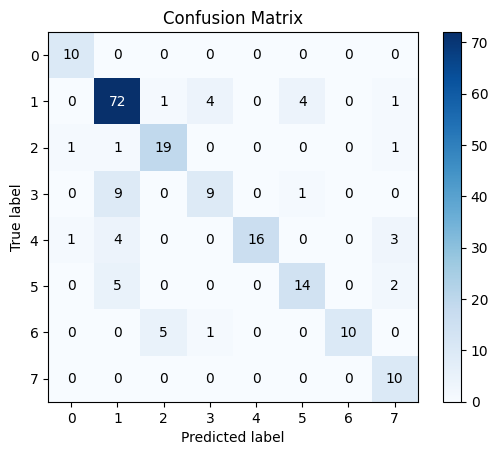

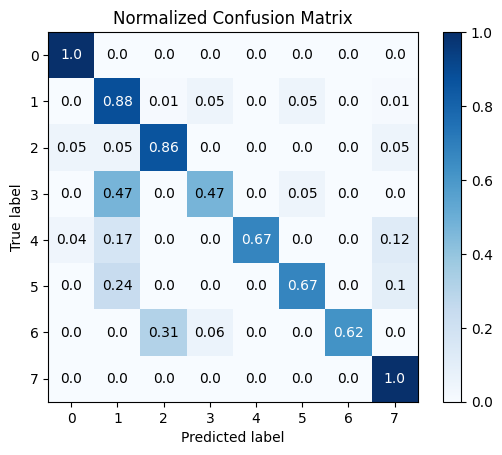

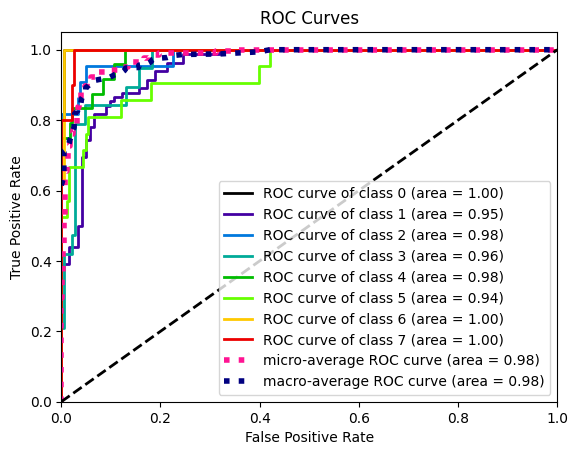

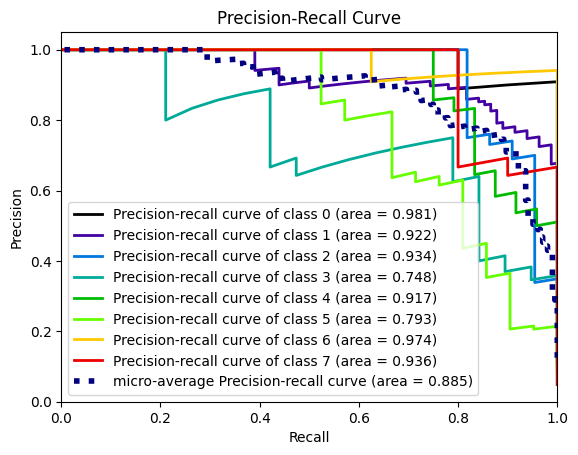

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####100x

In [ ]:
test_gen = dataset("./mag_test/100/",train = False)

Found 190 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 61s 20s/step - loss: 0.1974 - accuracy: 0.7842


Evaluate model with test set:
2/2 [==============================] - 3s 3s/step
Accuracy:  0.7842105263157895
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       0.86      0.89      0.87        89
           2       0.71      0.80      0.75        25
           3       0.75      0.64      0.69        14
           4       0.88      0.29      0.44        24
           5       0.58      0.88      0.70         8
           6       0.83      0.62      0.71         8
           7       0.76      1.00      0.87        13

    accuracy                           0.78       190
   macro avg       0.75      0.77      0.72       190
weighted avg       0.80      0.78      0.77       190



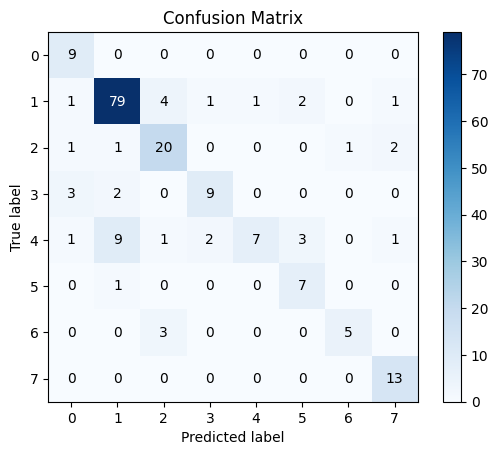

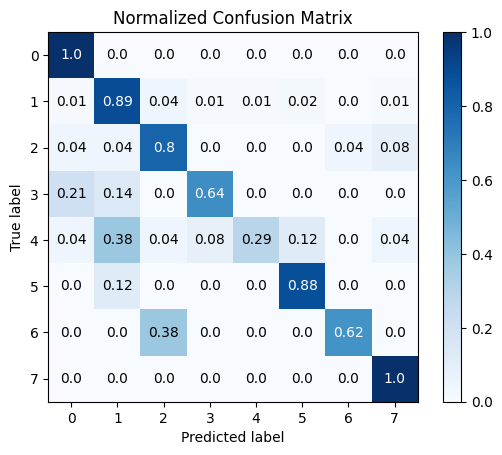

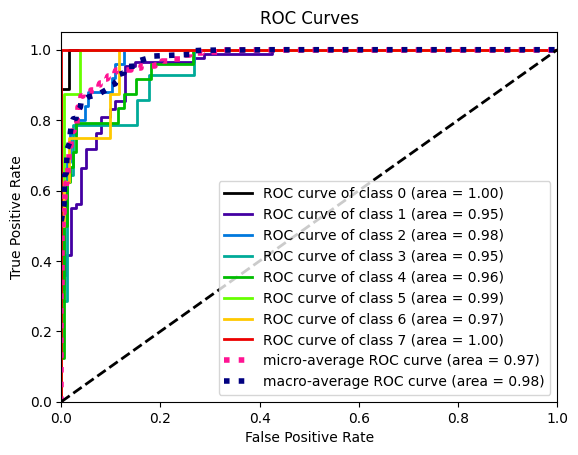

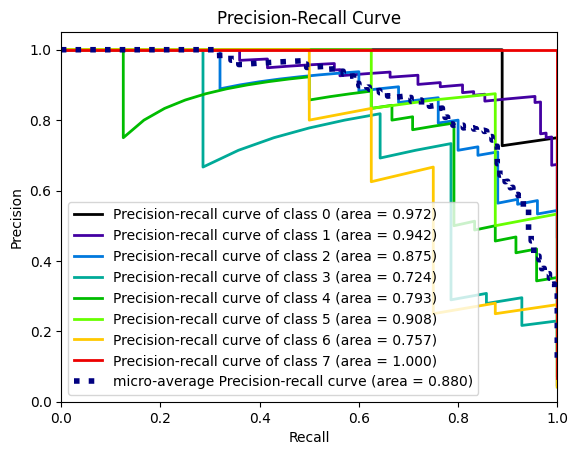

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####200x

In [ ]:
test_gen = dataset("./mag_test/200/",train = False)

Found 211 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 68s 29s/step - loss: 0.1610 - accuracy: 0.8436


Evaluate model with test set:
3/3 [==============================] - 3s 1s/step
Accuracy:  0.8436018957345972
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.87      0.90      0.89        92
           2       0.93      0.93      0.93        29
           3       0.69      0.52      0.59        21
           4       1.00      0.62      0.76        21
           5       0.52      0.92      0.67        13
           6       0.89      0.80      0.84        10
           7       0.92      1.00      0.96        12

    accuracy                           0.84       211
   macro avg       0.84      0.83      0.82       211
weighted avg       0.86      0.84      0.84       211



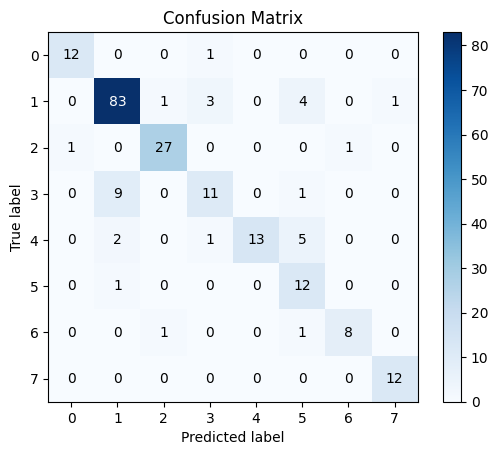

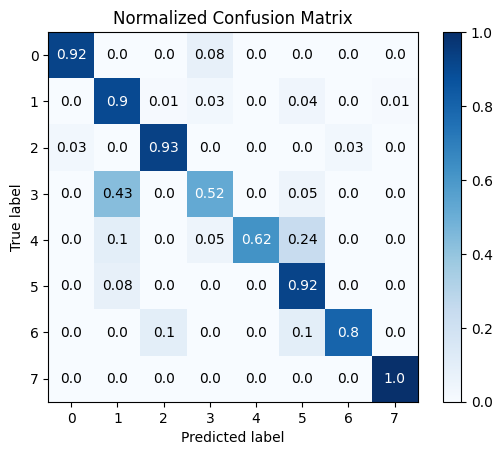

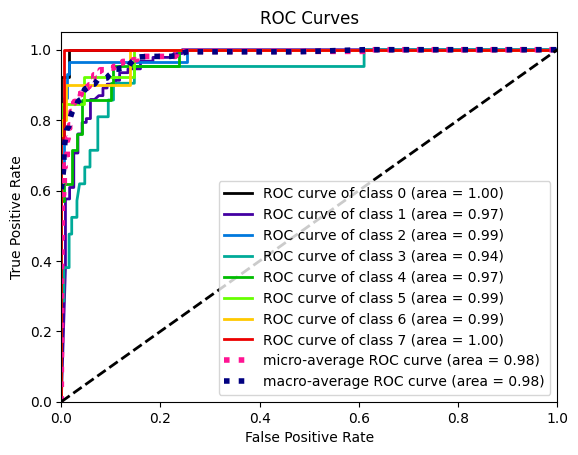

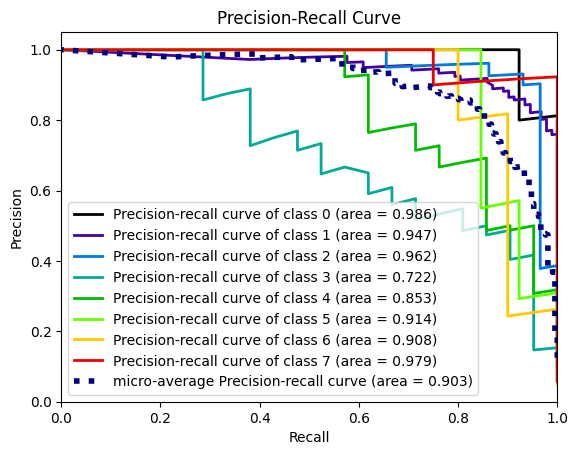

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####400x

In [ ]:
test_gen = dataset("./mag_test/400/",train = False)

Found 186 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 60s 19s/step - loss: 0.2268 - accuracy: 0.7742


Evaluate model with test set:
2/2 [==============================] - 3s 3s/step
Accuracy:  0.7741935483870968
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.86      0.84      0.85        76
           2       0.62      0.95      0.75        19
           3       0.75      0.25      0.38        12
           4       1.00      0.58      0.73        19
           5       0.50      0.93      0.65        14
           6       0.82      0.60      0.69        15
           7       0.88      0.83      0.86        18

    accuracy                           0.77       186
   macro avg       0.78      0.73      0.72       186
weighted avg       0.81      0.77      0.77       186



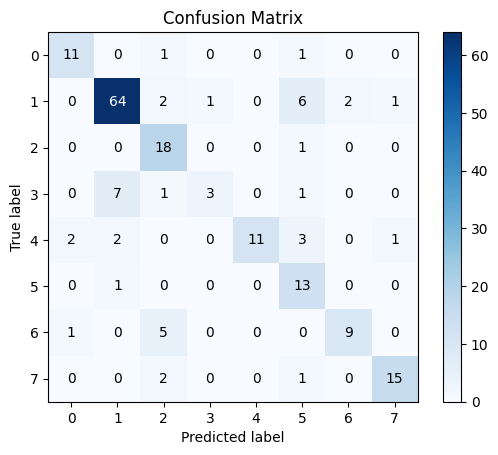

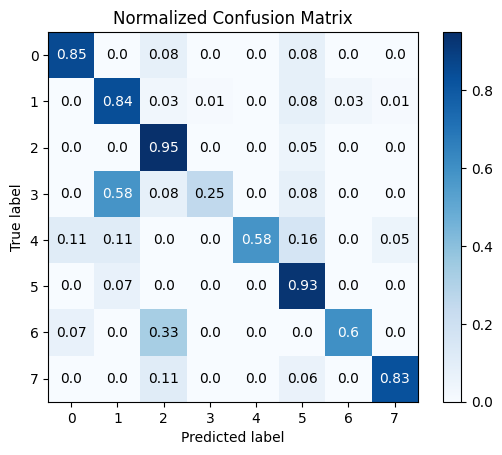

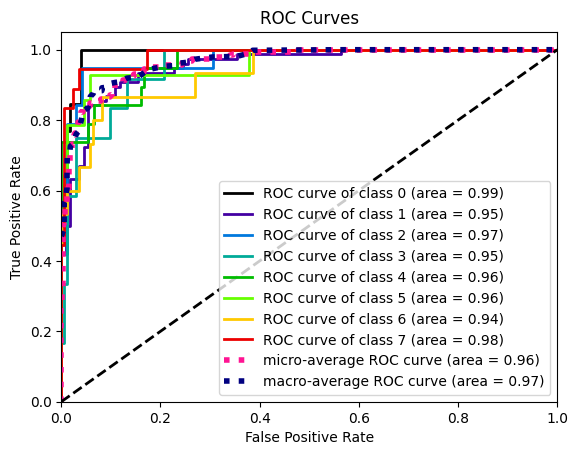

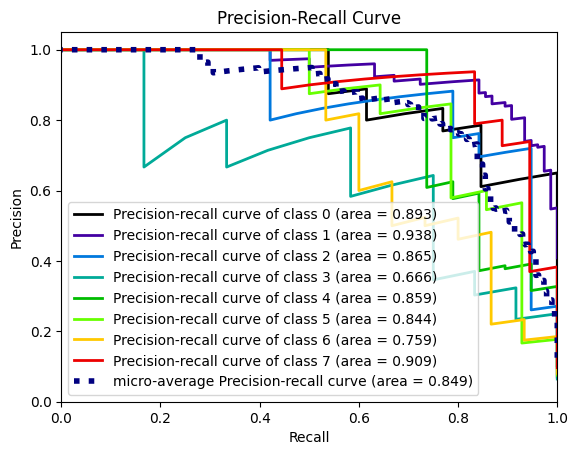

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)